# AutoEncoder Preliminary Results

### Libraries

In [1]:
%%capture
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.metrics import classification_report, roc_curve, PrecisionRecallDisplay, RocCurveDisplay, auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from keras.models import Sequential

import os
import glob
import fileinput
import matplotlib.pyplot as plt
import seaborn as sns

# Import autoencoder for TSC anamoly detection
!pip install pyod
from pyod.models.auto_encoder import AutoEncoder

### Import data and split into train/validation/test sets
For this initial report, we used a smaller subset of the data - scenarios 5, 6, 7, 11, 12

n.b. couldn't get 06 to work, so omitted

### Build CNN Auto-Encoder

Package for auto-encoder

Helpful for Time-Series Anamoly Detection 

Articles:

[Anamoly Detection with AutoEncoder](https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6)

[Machine Learning for Anamoly Detection and Condition Monitoring](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7)

In [2]:
# list of scenarios
scenarios = ['5.txt', '7.txt', '11.txt', '12.txt']
path = '/Users/Aidan/Desktop/Masters/CyberSec Network Analytics/Assignment1/Assignment1_data/'
# empty list to capture statistics for each scenario
results = []
precision_recall_all = pd.DataFrame()

# iterate over scenarios to build, train, and evaluate LSTM model
for filename in scenarios:

    scenario_name = filename.replace(".txt", "")
    # load the dataset
    scenario = np.loadtxt(path + filename, delimiter=',')

    # split into input (X) and output (y) variables
    X = scenario[:,1:]
    y = scenario[:,0]

    # split into training (80%), validation (10%), and test (10%) sets
    rand_seed = 123
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size = 0.8,
                                                      random_state = rand_seed,
                                                      stratify = y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, 
                                                        train_size = 0.5,
                                                        random_state = rand_seed,
                                                        stratify = y_rem)
    
    #Creating and fitting model
    model = AutoEncoder(contamination=0.05, hidden_neurons =[3, 3],
                        epochs=8, optimizer='Nadam')
    model.fit(X_train)
    
    #make predictions with model and print classification report
    predictions = (model.predict(X_test) > .5).astype(int)
    print(filename)
    print(classification_report(y_test, predictions))

    # calculate metrics for each model
    precision, recall, fscore, support = score(y_test, predictions, 
                                                   average = 'binary')
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)


    # append metrics to results
    results.append(
        {
            'Scenario': scenario_name,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': fscore,
            'AUC': auc
        })

    # write data for precision recall curves to csv
    cols = ['precision', 'recall', 'thresholds']
    precision_recall = precision_recall_curve(y_test, model.predict(X_test))
    precision_recall = pd.DataFrame(precision_recall, index = cols).transpose()
    precision_recall['scenario'] = filename
    precision_recall_all = precision_recall_all.append(precision_recall)

    print("scenario", filename, "complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                812       
                                                                 
 dropout (Dropout)           (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                812       
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 87        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1

C:\Users\Aidan\AppData\Local\Temp\ipykernel_21252\2409525720.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precision_recall_all = precision_recall_all.append(precision_recall)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 28)                812       
                                                                 
 dropout_4 (Dropout)         (None, 28)                0         
                                                                 
 dense_6 (Dense)             (None, 28)                812       
                                                                 
 dropout_5 (Dropout)         (None, 28)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 87        
                                                                 
 dropout_6 (Dropout)         (None, 3)                 0         
                                                                 
 dense_8 (Dense)             (None, 3)                

C:\Users\Aidan\AppData\Local\Temp\ipykernel_21252\2409525720.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precision_recall_all = precision_recall_all.append(precision_recall)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 28)                812       
                                                                 
 dropout_8 (Dropout)         (None, 28)                0         
                                                                 
 dense_11 (Dense)            (None, 28)                812       
                                                                 
 dropout_9 (Dropout)         (None, 28)                0         
                                                                 
 dense_12 (Dense)            (None, 3)                 87        
                                                                 
 dropout_10 (Dropout)        (None, 3)                 0         
                                                                 
 dense_13 (Dense)            (None, 3)                

C:\Users\Aidan\AppData\Local\Temp\ipykernel_21252\2409525720.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precision_recall_all = precision_recall_all.append(precision_recall)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 28)                812       
                                                                 
 dropout_12 (Dropout)        (None, 28)                0         
                                                                 
 dense_16 (Dense)            (None, 28)                812       
                                                                 
 dropout_13 (Dropout)        (None, 28)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                 87        
                                                                 
 dropout_14 (Dropout)        (None, 3)                 0         
                                                                 
 dense_18 (Dense)            (None, 3)                

C:\Users\Aidan\AppData\Local\Temp\ipykernel_21252\2409525720.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precision_recall_all = precision_recall_all.append(precision_recall)


In [3]:
results_df = pd.DataFrame(results).sort_values('Scenario')
results_df

,Scenario,Precision,Recall,F1 Score,AUC
2,11,0.001942,0.001224,0.001502,0.474676
3,12,0.000644,0.004608,0.001129,0.478287
0,5,0.000000,0.000000,0.000000,0.474950
1,7,0.000000,0.000000,0.000000,0.474873


In [4]:
# print results and precision_recall to csv
# results_df.to_csv('results.csv') 
# precision_recall_all.to_csv('precision_recall.csv')

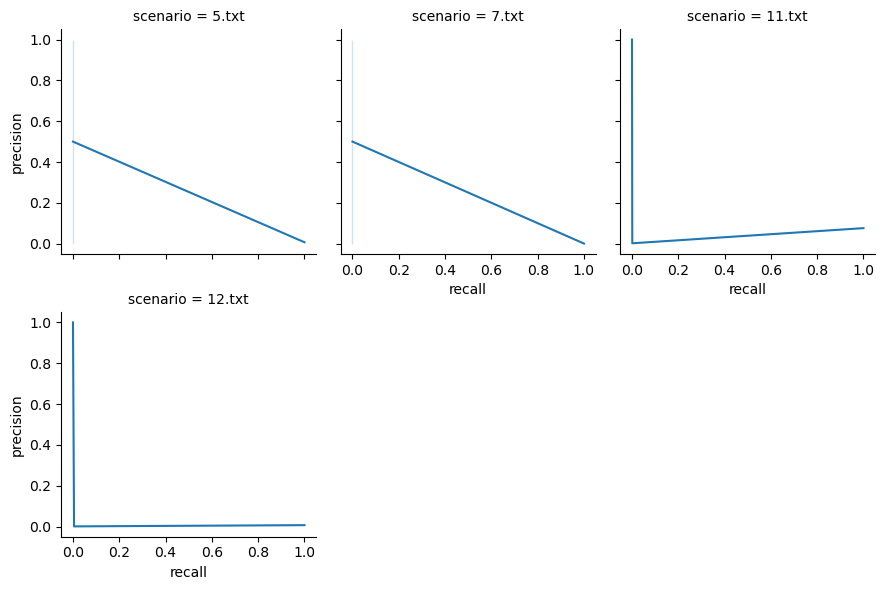

In [5]:
# precision recall graphs for each scenario
graph = sns.FacetGrid(precision_recall_all, col = 'scenario', col_wrap = 3)
graph.map(sns.lineplot, 'recall', 'precision')